In [1]:
!pip uninstall tensorflow keras tf-keras -y
!pip install tensorflow==2.15.0
!pip install tf-keras==2.15.1
!pip install keras==2.15.0

Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Successfully uninstalled tensorflow-2.17.0
Found existing installation: keras 3.4.1
Uninstalling keras-3.4.1:
  Successfully uninstalled keras-3.4.1
Found existing installation: tf_keras 2.17.0
Uninstalling tf_keras-2.17.0:
  Successfully uninstalled tf_keras-2.17.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.2 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtyp

In [6]:
len(tf.config.list_physical_devices('GPU'))

1

# Initialization

In [7]:
import tensorflow as tf

### Configuration
create_dataset = False

def in_google_colab():
    """Checks if the code is running in Google Colab

    Returns:
        bool: _description_
    """
    try:
        import google.colab
        return True
    except ImportError:
        return False

if in_google_colab():
    print("Running in Google Colab")
    # Install necessary packages in Google Colab
    !rm -r sample_data/
    !git clone https://github.com/naderinho/anesthesia_anomaly_detection
    !cp -r anesthesia_anomaly_detection/* .
    !rm -r anesthesia_anomaly_detection/
    !pip install vitaldb
    create_dataset = False
else:
    print("Running locally")

### Datasetpath
directory = 'data/'
datasetpath = 'dataset02/'
vitaldbpath = 'vitaldb_tiva/'

### Import the necessary libraries
import numpy as np
import pandas as pd
import vitaldb as vf
import matplotlib.pyplot as plt
import pickle

### Custom functions
import modules as md

Running in Google Colab
Cloning into 'anesthesia_anomaly_detection'...
remote: Enumerating objects: 1379, done.
remote: Total 1379 (delta 0), reused 0 (delta 0), pack-reused 1379 (from 1)
Receiving objects: 100% (1379/1379), 281.40 MiB | 25.48 MiB/s, done.
Resolving deltas: 100% (834/834), done.
Updating files: 100% (494/494), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 5.4 MB/s eta 0:00:00


# Data loading

In [11]:
### Load the datasets
bis = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
bis.load('00_bis.npz')

bloodpressure = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
bloodpressure.load('02_bloodpressure.npz')


info = md.infoImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
info.load('01_info.npz')

propofolrate = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
propofolrate.load('03_propofol_rate.npz')

train_index, val_index, test_index = bis.split(np.array(bis.index))

# Model creation

In [19]:
########################################## COMBINED MODEL ##########################################
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, LSTM, Dense, ReLU, Dropout, Concatenate, Masking, Conv1D, MaxPooling1D, BatchNormalization, RepeatVector, Lambda
from tensorflow.keras.metrics import RootMeanSquaredError, MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError

input_bp = Input(shape=(None, bloodpressure.train_dataset.shape[2]))
bp_layer = Masking(mask_value=0.0)(input_bp)
bp_layer = Dense(units=1, activation=ReLU(max_value=0.00000001))(bp_layer)

# Propofol layers
input_propofol = Input(shape=(None, propofolrate.train_dataset.shape[2]))
propofol_layer = BatchNormalization()(input_propofol)
propofol_layer = LSTM(units=64, return_sequences=True)(propofol_layer)
propofol_layer = BatchNormalization()(propofol_layer)
propofol_layer = LSTM(units=64, return_sequences=True)(propofol_layer)
propofol_layer = BatchNormalization()(propofol_layer)
propofol_layer = LSTM(units=64, return_sequences=True)(propofol_layer)
propofol_layer = BatchNormalization()(propofol_layer)
propofol_layer = LSTM(units=64, return_sequences=True)(propofol_layer)
propofol_layer = BatchNormalization()(propofol_layer)
propofol_layer = LSTM(units=128, return_sequences=True)(propofol_layer)
propofol_layer = BatchNormalization()(propofol_layer)
propofol_layer = LSTM(units=64, return_sequences=True)(propofol_layer)
propofol_layer = BatchNormalization()(propofol_layer)
propofol_layer = LSTM(units=16, return_sequences=True)(propofol_layer)
propofol_layer = BatchNormalization()(propofol_layer)
propofol_layer = LSTM(units=16, return_sequences=True)(propofol_layer)
propofol_layer = BatchNormalization()(propofol_layer)
propofol_layer = Dense(units=16, activation='linear')(propofol_layer)

### INFO layers
input_info = Input(shape=(info.train_dataset.shape[1],))
info_layer = RepeatVector(propofolrate.train_dataset.shape[1])(input_info)
info_layer = Dense(units=16, activation='linear')(info_layer)
info_layer = Dense(units=16, activation='sigmoid')(info_layer)


## Concatenate the Propofol output with the info layer
comb_layer = Concatenate([bp_layer, propofol_layer, info_layer])
comb_layer = Dense(units=64, activation='linear')(propofol_layer)
comb_layer = Dense(units=64, activation='relu')(comb_layer)
comb_layer = Dense(units=64, activation='relu')(comb_layer)
comb_layer = Dense(units=32, activation='relu')(comb_layer)
comb_layer = Dense(units=16, activation='relu')(comb_layer)
comb_layer = Dense(units=1, activation=ReLU(max_value=1.0))(comb_layer)
output = Lambda(lambda x: x * 100)(comb_layer)

# Define the model
model = Model(inputs=[input_bp, input_propofol, input_info], outputs=output)

# Compile the model
optimizer = Adam(learning_rate=0.0005)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['MeanSquaredError','MeanAbsoluteError','RootMeanSquaredError']
              )

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, None, 1)]            0         []                            
                                                                                                  
 batch_normalization_45 (Ba  (None, None, 1)              4         ['input_13[0][0]']            
 tchNormalization)                                                                                
                                                                                                  
 lstm_40 (LSTM)              (None, None, 64)             16896     ['batch_normalization_45[0][0]
                                                                    ']                            
                                                                                            

# Model Training

In [20]:
# Rolling mean on BIS data
y = pd.DataFrame(bis.train_dataset[:,:,0].T).rolling(min_periods=1,window=3, center=True).mean().to_numpy().T[:,:,np.newaxis]

class SaveModelHistoryCallback(tf.keras.callbacks.Callback):
    def __init__(self, save_interval, model_path, history_path):
        super(SaveModelHistoryCallback, self).__init__()
        self.save_interval = save_interval
        self.model_path = model_path
        self.history_path = history_path
        self.history = []

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_interval == 0:
            # Save model
            self.model.save(self.model_path.format(epoch=epoch+1))
            # Save history
            self.history.append(logs)
            with open(self.history_path.format(epoch=epoch+1), 'wb') as f:
                pickle.dump(self.history, f)

save_interval = 20
model_path = 'model_epoch_{epoch}.h5'
history_path = 'history_epoch_{epoch}.pkl'
save_model_history_callback = SaveModelHistoryCallback(save_interval, model_path, history_path)


if in_google_colab():
    # Train the model
    history = model.fit([bloodpressure.train_dataset, propofolrate.train_dataset, info.train_dataset],
                        y,
                        validation_data=([bloodpressure.validation_dataset, propofolrate.validation_dataset, info.validation_dataset], bis.validation_dataset),
                        epochs=150,
                        callbacks=[save_model_history_callback],
                        batch_size=4
                        )

    train_score = history.history

    # Save the model
    model.save('download/model.keras')

    # Save the training history
    with open('download/train_score.pkl', 'wb') as f:
        pickle.dump(train_score, f)

    # Save the prediction
    y_pred = model.predict([bloodpressure.test_dataset, propofolrate.test_dataset, info.test_dataset], verbose=0)
    with open('download/prediction.pkl', 'wb') as f:
        pickle.dump(y_pred, f)

else:
    # Load train score data
    with open('train_score.pkl', 'rb') as f:
        train_score = pickle.load(f)

    # Load test prediction data
    with open('prediction.pkl', 'rb') as f:
        y_pred = pickle.load(f)

Epoch 1/150
28/28 [==============================] - 77s 894ms/step - loss: 279.1310 - mean_squared_error: 279.1310 - mean_absolute_error: 9.7274 - root_mean_squared_error: 16.7072 - val_loss: 768.2846 - val_mean_squared_error: 768.2846 - val_mean_absolute_error: 17.6476 - val_root_mean_squared_error: 27.7179
Epoch 2/150
28/28 [==============================] - 28s 1s/step - loss: 132.9122 - mean_squared_error: 132.9122 - mean_absolute_error: 5.7064 - root_mean_squared_error: 11.5288 - val_loss: 555.3196 - val_mean_squared_error: 555.3196 - val_mean_absolute_error: 20.0295 - val_root_mean_squared_error: 23.5652
Epoch 3/150
28/28 [==============================] - 22s 803ms/step - loss: 115.2290 - mean_squared_error: 115.2290 - mean_absolute_error: 4.8793 - root_mean_squared_error: 10.7345 - val_loss: 543.2529 - val_mean_squared_error: 543.2528 - val_mean_absolute_error: 21.4490 - val_root_mean_squared_error: 23.3078
Epoch 4/150
28/28 [==============================] - 22s 798ms/step - 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 22s 772ms/step - loss: 81.1778 - mean_squared_error: 81.1778 - mean_absolute_error: 4.1213 - root_mean_squared_error: 9.0099 - val_loss: 1628.8961 - val_mean_squared_error: 1628.8961 - val_mean_absolute_error: 34.0243 - val_root_mean_squared_error: 40.3596
Epoch 22/150
28/28 [==============================] - 22s 803ms/step - loss: 79.3109 - mean_squared_error: 79.3108 - mean_absolute_error: 4.1233 - root_mean_squared_error: 8.9057 - val_loss: 1949.4004 - val_mean_squared_error: 1949.4004 - val_mean_absolute_error: 36.7525 - val_root_mean_squared_error: 44.1520
Epoch 23/150
28/28 [==============================] - 22s 782ms/step - loss: 77.7136 - mean_squared_error: 77.7136 - mean_absolute_error: 4.0731 - root_mean_squared_error: 8.8155 - val_loss: 1907.9856 - val_mean_squared_error: 1907.9855 - val_mean_absolute_error: 36.4248 - val_root_mean_squared_error: 43.6805
Epoch 24/150
28/28 [==============================] - 20s 733ms/step - loss: 76.

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_4" expects 3 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 3680, 1) dtype=float32>]


In [21]:
y_pred = model.predict([bloodpressure.test_dataset, propofolrate.test_dataset, info.test_dataset], verbose=0)
with open('download/prediction.pkl', 'wb') as f:
    pickle.dump(y_pred, f)

# Training results

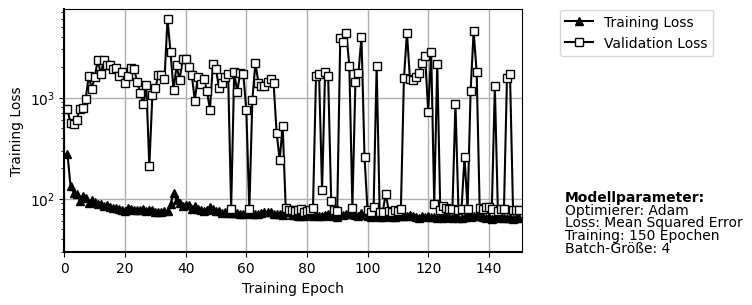

In [22]:
from utils.plotting import training_loss_plot

plot = training_loss_plot(train_score, filename='download/training_loss.pdf')
plot.show()

# Testing

In [23]:
### Predict on the test set
from utils.evaluation import phases_report, phases_report_std

print('Testmetriken:')

report = phases_report(y_pred, bis.test_dataset, propofolrate.test_dataset)
report

Testmetriken:


,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,102.05,139.87,6.80,7.55,10.10,11.83
Induction,134.28,637.60,9.03,18.34,11.59,25.25
Maintenance,57.45,60.90,5.70,5.68,7.58,7.80
Recovery,396.96,361.57,12.96,13.46,19.92,19.02


In [24]:
phases_report_std(report, y_pred, bis.test_dataset, propofolrate.test_dataset)

All      	min: 	 15 	max: 	 6
Induction 	min: 	 23 	max: 	 10
Maintenance 	min: 	 13 	max: 	 6
Recovery 	min: 	 19 	max: 	 22


,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,82.09,82.42,2.21,2.54,3.25,3.31
Induction,98.56,403.81,3.97,8.45,4.05,7.29
Maintenance,37.75,43.11,2.02,2.15,2.35,2.51
Recovery,269.53,185.95,6.01,6.28,8.24,6.47


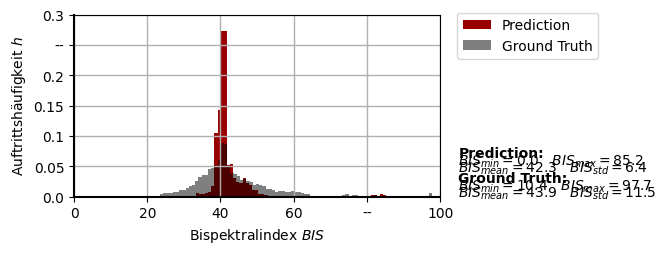

In [25]:
from utils.plotting import full_histogramm_plot

plot = full_histogramm_plot(groundtruth = bis.test_dataset, prediction = y_pred, filename='download/histogramm.pdf')
plot.show()

/content/utils/plotting.py:79: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12/2.54, 6/2.54))


Finished


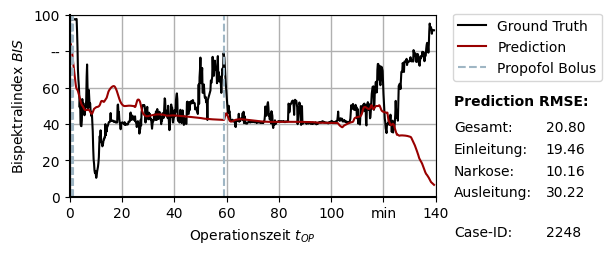

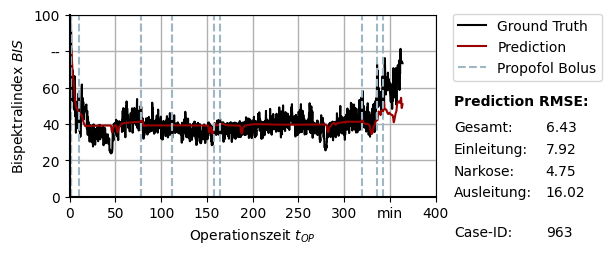

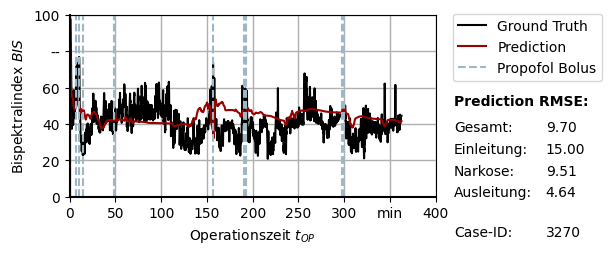

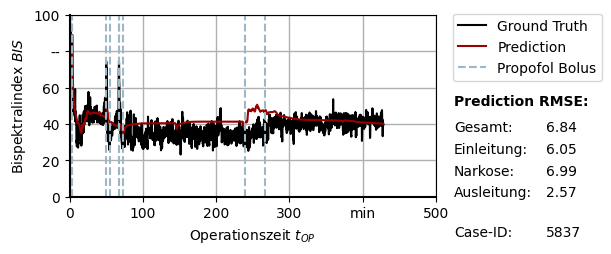

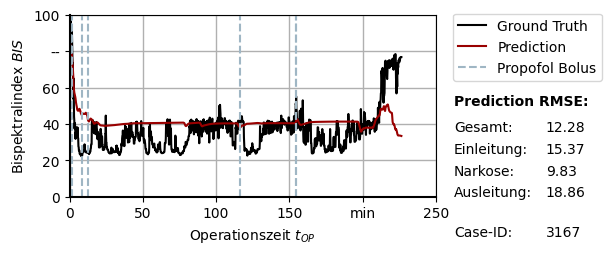

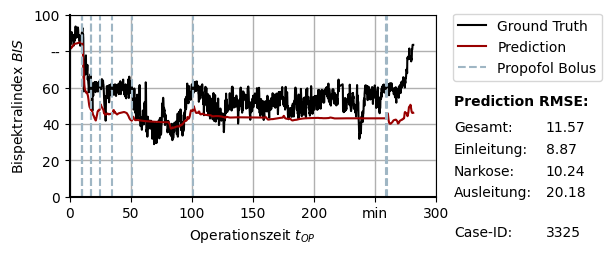

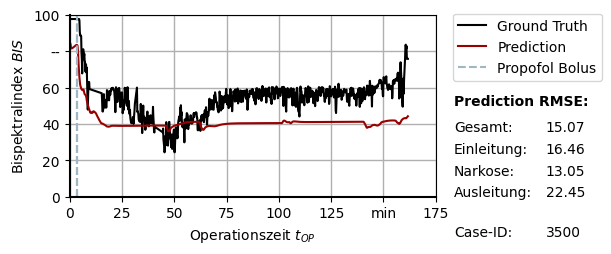

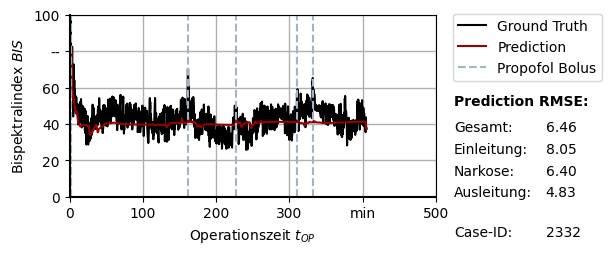

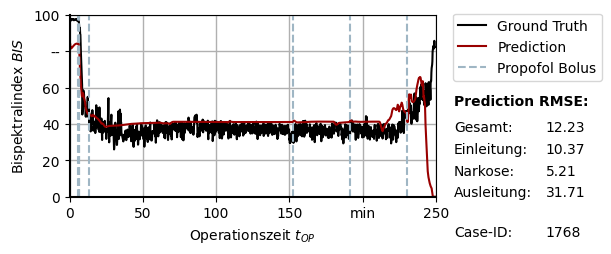

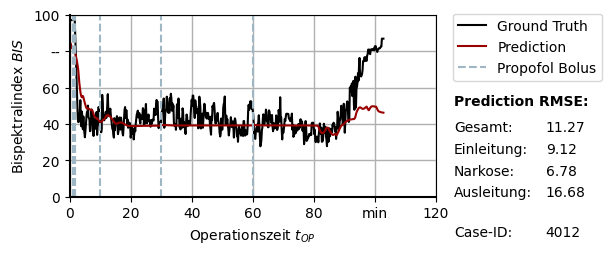

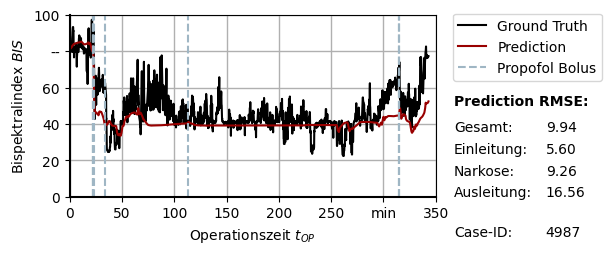

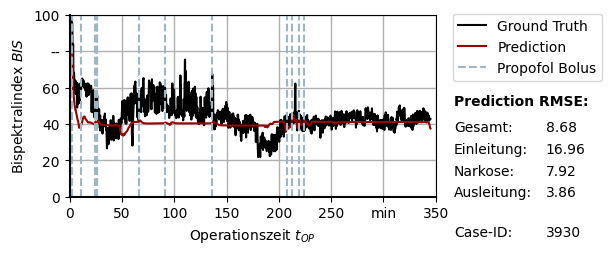

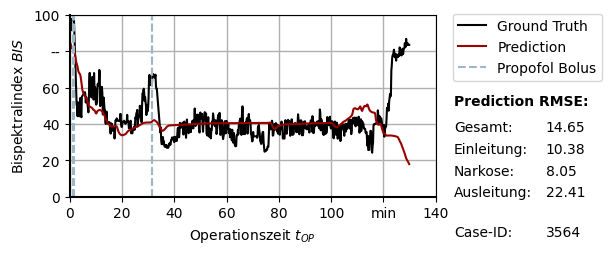

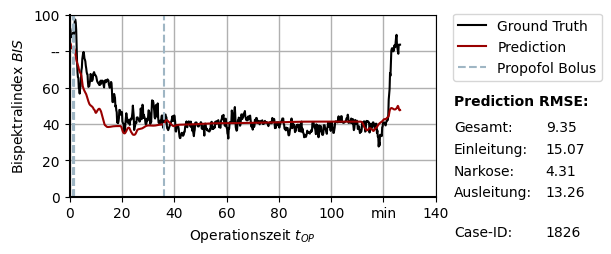

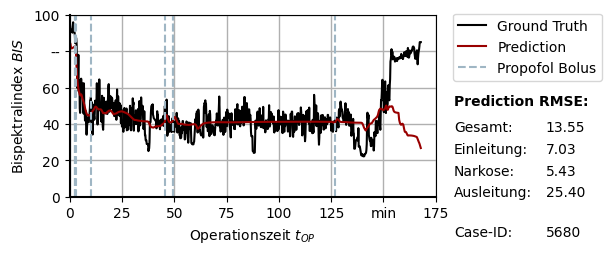

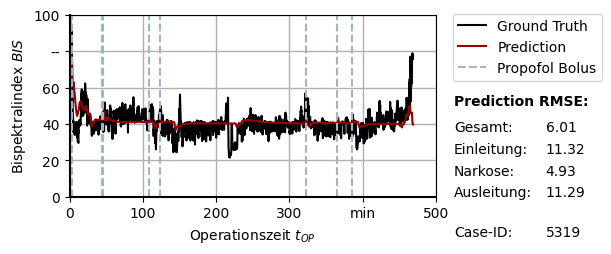

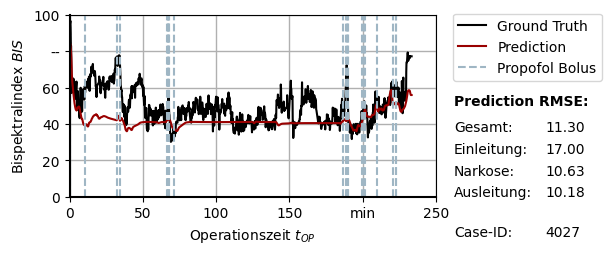

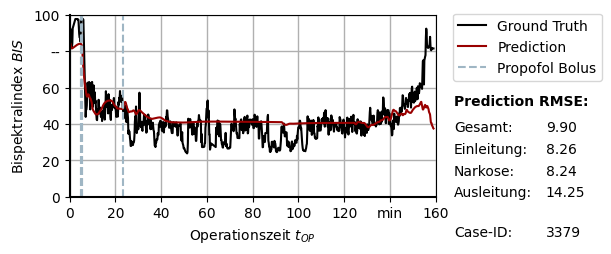

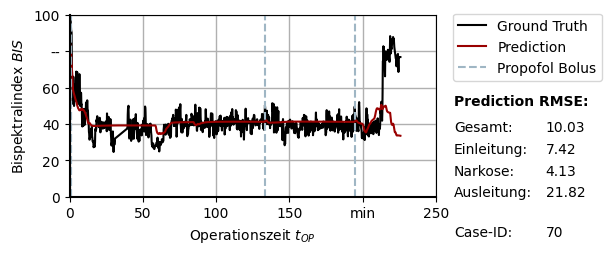

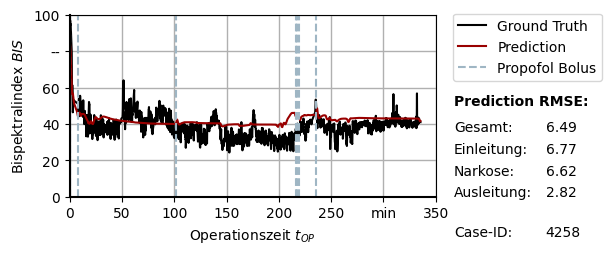

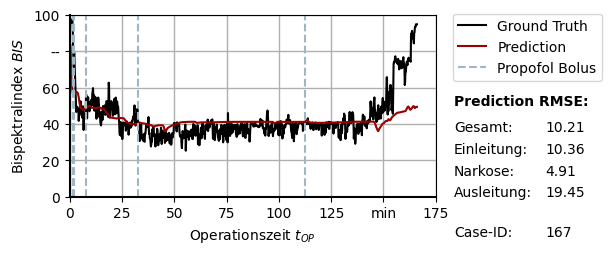

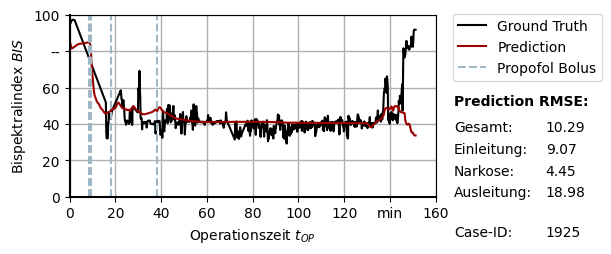

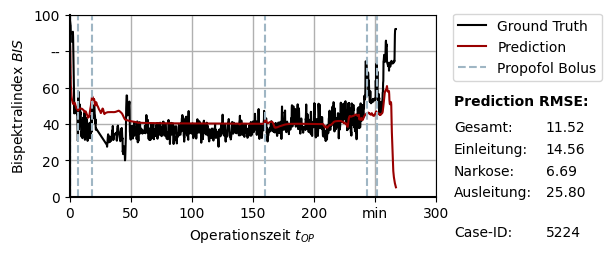

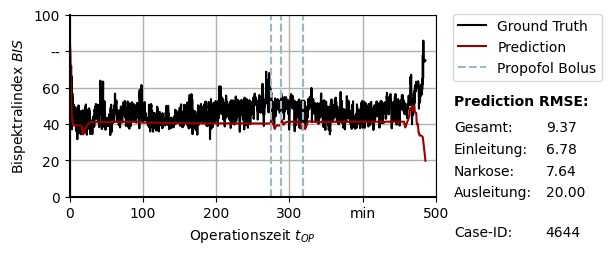

In [26]:
from utils.plotting import single_prediction_plot

for case in test_index:
    single_prediction_plot(
        case = case,
        index = test_index,
        groundtruth = bis.test_dataset,
        prediction = y_pred,
        infusion = propofolrate.test_dataset,
        error = 'Prediction RMSE',
        filename = 'download/' + str(case) + '.pdf')

print('Finished')

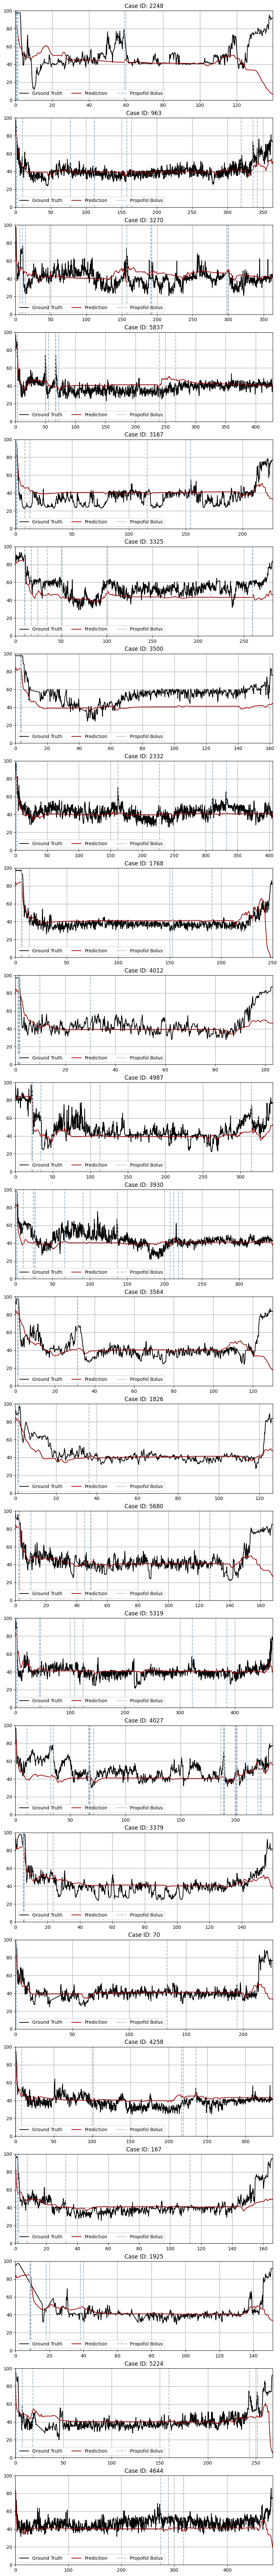

In [27]:
from utils.plotting import full_prediction_plot

full_prediction_plot(index = test_index, groundtruth = bis.test_dataset, prediction = y_pred, infusion = propofolrate.test_dataset)